## 一、背景
每年国际上召开的大大小小学术会议不计其数，发表了非常多的论文。在计算机领域的一些大型学术会议上，一次就可以发表涉及各个方向的几百篇论文。按论文的主题、内容进行聚类，有助于人们高效地查找和获得所需要的论文。本案例数据来源于AAAI 2014上发表的约400篇文章，由[UCI](https://archive.ics.uci.edu/dataset/307/aaai+2014+accepted+papers)公开提供，提供包括标题、作者、关键词、摘要在内的信息，希望大家能根据这些信息，合理地构造特征向量来表示这些论文，并设计实现或调用聚类算法对论文进行聚类。最后也可以对聚类结果进行观察，看每一类都是什么样的论文，是否有一些主题。



## 二、任务
* 将文本转化为向量，实现或调用无监督聚类算法，对论文聚类，例如10类（可使用已有工具包例如sklearn）；
* 观察每一类中的论文，调整算法使结果较为合理；
* 对文本向量进行降维，并将聚类结果可视化成散点图。



## 三、评价指标
无监督聚类没有标签，效果较难评价，因此没有硬性指标。人工为主，了解和感受聚类算法，比较简单。

本案后继中参考轮廓系数（Silhouette Coefficient）、CH分数（Calinski Harabasz Score ）和 戴维森堡丁指数(Davies Bouldin Score）结合评价。SC值越大，说明同类样本相距约近，不同样本相距越远，则聚类效果越好；CH index的数值越大越好。DBI的值值越小代表聚类效果越好。因此，使用SC\*CH\*(1/db)来综合评价。

## 四、数据概览

group和topic也不能完全算是标签，因为
1. 有些文章作者投稿时可能会选择某个group/topic但实际和另外group/topic也相关甚至更相关；
2. 一篇文章可能有多个group和topic，作为标签会出现有的文章同属多个类别，这里暂不考虑这样的聚类；
3. group和topic的取值很多，但聚类常常希望指定聚合成出例如5/10/20类；
4. 感兴趣但同学可以思考利用group和topic信息来量化评价无监督聚类结果，不作要求。


## 五、模型构建

### 5.1 数据集加载

In [18]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv('data/[UCI] AAAI-14 Accepted Papers - Papers.csv')
date_evaluation = df[['keywords', 'groups', 'topics']].copy()                            # 取出最能代表文章主题的三个特征作为后面的评价指标
date_evaluation = date_evaluation.fillna('')                                             # 处理空评价指标
date_feature = df[['title','authors','keywords','abstract']].copy()                      # group和topic不能完全算是标签，去除

训练集的特征统计一览

In [2]:
date_feature.describe()                                                                 # 训练集的特征统计一览

,title,authors,keywords,abstract
count,398,398,398,398
unique,398,391,398,398
top,Kernelized Bayesian Transfer Learning,"Deguang Kong, Chris Ding and Qihe Pan",cross-domain learning\ndomain adaptation\nkern...,Transfer learning considers related but distin...
freq,1,3,1,1


量化评价信息统计一览

In [3]:

date_evaluation.describe()                                                              # 量化评价信息统计一览

,keywords,groups,topics
count,398,398,398
unique,398,126,351
top,cross-domain learning\ndomain adaptation\nkern...,Novel Machine Learning Algorithms (NMLA),GTEP: Social Choice / Voting
freq,1,50,7


### 5.2 特征提取

使用词袋模型对每个特征进行抽象。去除只出现一次频率的词汇。

In [4]:
cv = CountVectorizer(min_df=2, max_df=1.0)                                              # 文本特征提取
feature_x = [[i] for i in range(date_feature.shape[0])]

for x in date_feature.columns:
    tmp = cv.fit_transform(date_feature[x])                                            
    feature_x = np.concatenate((feature_x, tmp.toarray()), axis=1)                     
    
print(feature_x)
feature_x.shape

[[  0   0   0 ...   0   0   0]
 [  1   0   0 ...   0   0   0]
 [  2   0   0 ...   0   0   0]
 ...
 [395   0   0 ...   0   0   0]
 [396   0   0 ...   0   0   4]
 [397   0   0 ...   0   0   0]]


(398, 4405)

### 5.3 聚类模型和调参

高维向量的降维旨在去除一些高相关性的特征维度，保留最有用的信息，用更低维的向量表示高维数据，常用的方法有PCA和t-SNE等； 降维与聚类是两件不同的事情，聚类实际上在降维前的高维向量和降维后的低维向量上都可以进行，结果也可能截然不同；高维向量做聚类，降维可视化后若有同一类的点不在一起，是正常的。在高维空间中它们可能是在一起的，降维后损失了一些信息。

使用PCA提取主成分进行降维，对降维后的数据进行聚类，遍历获得表现最好的n_components和k值。聚类的效果较难评价，本案中采取轮廓系数（Silhouette Coefficient）、CH分数（Calinski Harabasz Score ）和 戴维森堡丁指数(Davies Bouldin Score）结合评价。SC值越大，说明同类样本相距约近，不同样本相距越远，则聚类效果越好；CH index的数值越大越好。DBI的值值越小代表聚类效果越好。因此，使用SC\*CH\*(1/db)来综合评价。

In [5]:
cv = CountVectorizer(min_df=0.0, max_df=1.0)
evaluation_x = [[i] for i in range(df.shape[0])]
for col in date_evaluation.columns:
    tmp = cv.fit_transform(date_evaluation[col])
    feature = tmp.toarray()
    evaluation_x = np.concatenate((evaluation_x, feature), axis=1)

exec_reult = pd.DataFrame(columns=['k', 'cmp', 'sc', 'ch', 'db','score'])                       # 记录模型参数和评价
cmps=range(2, 10)
ks=range(2, 30)
for _cmp in cmps:
    pca_x = PCA(n_components=_cmp).fit_transform(feature_x)                                     # PCA提取主成分进行降维
    for _k in ks:
        model = KMeans(n_clusters=_k)
        res = model.fit_predict(pca_x)
        sc = silhouette_score(evaluation_x, res)
        ch = calinski_harabasz_score(evaluation_x, res)
        db = davies_bouldin_score(evaluation_x, res)
        exec_reult.loc[exec_reult.shape[0]]=[_k, _cmp, sc, ch, db, sc*ch*(1/db)]                # 使用SC*CH*（1/db)来综合评价。

print('score:')
best = exec_reult['score'].idxmax()
exec_reult_best = exec_reult.loc[best]
print(exec_reult_best)

score:
k           9.000000
cmp         4.000000
sc          0.470204
ch       3207.305695
db          0.590010
score    2556.036735
Name: 63, dtype: float64


**聚类为9类，提取特征为4维时，效果较好。** 聚类的个数变化对效果的影响如下：

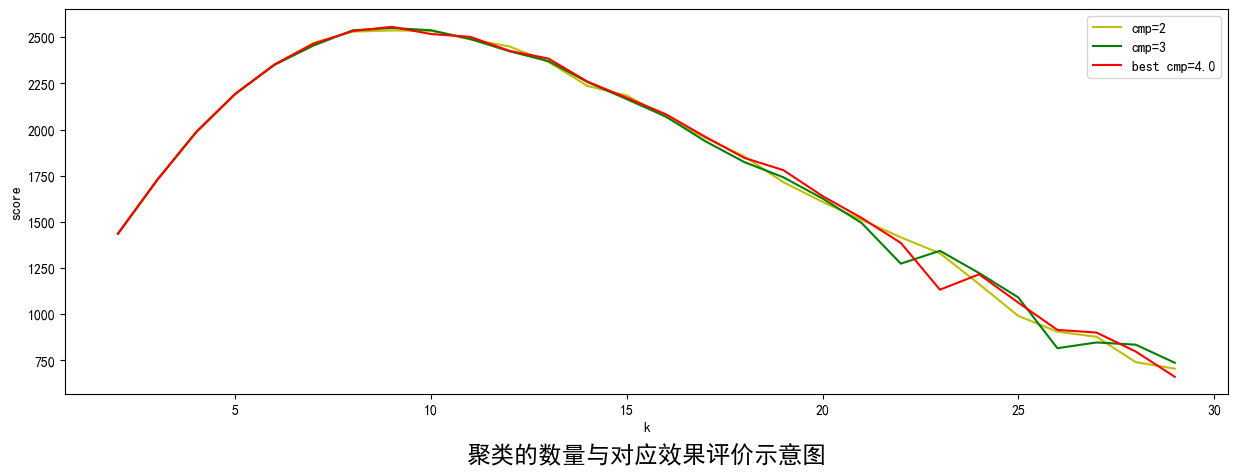

In [16]:
plt.figure(figsize=(15, 5), dpi=100)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签

plt.plot(ks,exec_reult.query("cmp==2")['score'].values.tolist(),label='cmp=2', c='y')                   # 提取特征为2维时效果
plt.plot(ks,exec_reult.query("cmp==3")['score'].values.tolist(),label='cmp=3', c='g')                   # 提取特征为3维时效果
plt.plot(ks,exec_reult.query("cmp==" + str(exec_reult_best.cmp) )['score'].values.tolist(),label='best cmp=' + str(exec_reult_best.cmp), c='r')
plt.xlabel('k')
plt.ylabel('score')
plt.title("聚类的数量与对应效果评价示意图",fontsize='xx-large',fontweight='heavy',y=-0.2)
plt.legend()
plt.show()


由图可见，提取征在2维和3维下，都是在K=9时取得最好效果。总体效果差异不大。用聚类的效果可以用2维和3维图示来表示。

### 5.4 聚类结果可视化

在聚类为9个类时，2维、3维和4维的效果差异并不大。可视化中，考虑通过映射至2维和3维，分别使用PCA和TSNE两种方法直观展示聚类效果。

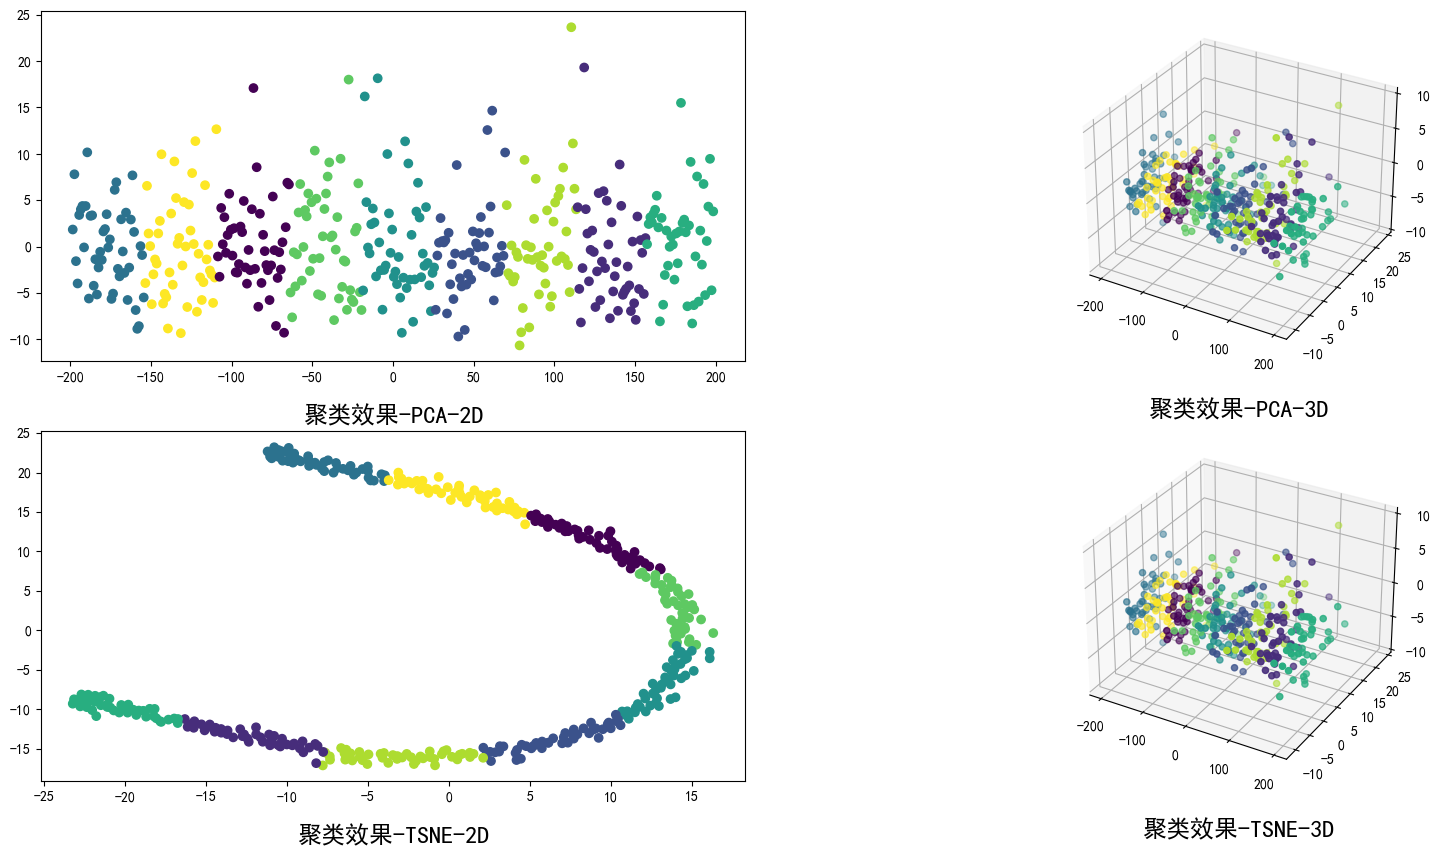

In [37]:
pca_x = PCA(n_components=4).fit_transform(feature_x)
model = KMeans(n_clusters=9)
res = model.fit_predict(pca_x)

pca_x_2 = PCA(n_components=2).fit_transform(pca_x)                                                  # PCA-2维
pca_x_2 = np.hstack((pca_x_2, [[r] for r in res]))
pca_x_3 = PCA(n_components=3).fit_transform(pca_x)                                                  # PCA-3维
pca_x_3 = np.hstack((pca_x_3, [[r] for r in res]))

tsne_x_2 = TSNE(n_components=2,learning_rate='auto', init='random').fit_transform(pca_x)            # TSNE-2维
tsne_x_2 = np.hstack((tsne_x_2, [[r] for r in res]))
tsne_x_3 = TSNE(n_components=3,learning_rate='auto', init='random').fit_transform(pca_x)            # TSNE-3维
tsne_x_3 = np.hstack((tsne_x_3, [[r] for r in res]))

fig = plt.figure(figsize=(20, 10), dpi=100)
plt.rcParams['font.sans-serif'] = ['SimHei']                                                        # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False                                                          # 用来正常显示负号
ax1 =fig.add_subplot(221)
ax1.scatter(pca_x_2[:, 0], pca_x_2[:, 1],c =pca_x_2[:,2])
ax1.set_title("聚类效果-PCA-2D",fontsize='xx-large',fontweight='heavy',y=-0.2)
ax2 =fig.add_subplot(222,projection='3d')
ax2.scatter(pca_x_3[:, 0], pca_x_3[:, 1], pca_x_3[:,2],c =pca_x_3[:,3])
ax2.set_title("聚类效果-PCA-3D",fontsize='xx-large',fontweight='heavy',y=-0.2)
ax3 =fig.add_subplot(223)
ax3.scatter(tsne_x_2[:, 0], tsne_x_2[:, 1],c =tsne_x_2[:,2])
ax3.set_title("聚类效果-TSNE-2D",fontsize='xx-large',fontweight='heavy',y=-0.2)
ax4 =fig.add_subplot(224,projection='3d')
ax4.scatter(pca_x_3[:, 0], pca_x_3[:, 1], pca_x_3[:,2],c =pca_x_3[:,3])
ax4.set_title("聚类效果-TSNE-3D",fontsize='xx-large',fontweight='heavy',y=-0.2)
plt.show()

聚类效果从2维上来看， PCA和TSNE方法呈现的不同，TSNE稍直观些；聚类效果从3维上来看，PCA和TSNE方法呈现比较近似。总体上来说，聚类为9类时，效果还是很不错的。